In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: GeForce RTX 2070


In [8]:
df_train=pd.read_csv("./train.csv")
df_test=pd.read_csv("./test.csv")

In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

df_train['text'] = df_train['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)
df_train=df_train[df_train["text"]!='']

In [11]:
df_train=df_train[["text","target"]]
df_train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [12]:
df_train["target"].value_counts()

0    4314
1    3247
Name: target, dtype: int64

In [13]:
# Get the lists of lyrics and their labels.
texts = df_train.text.values
labels = df_train.target.values

In [14]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [15]:
import torch
import torchvision.models
import hiddenlayer as hl

In [16]:
print(model)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

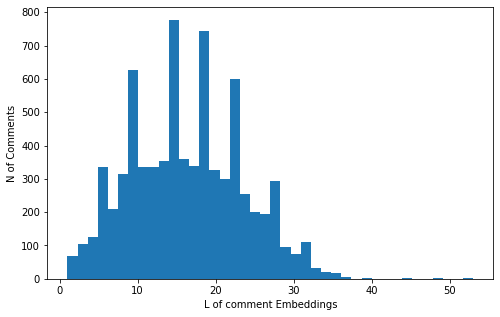

In [21]:
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_text_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(tokenized_text_len, bins=40)
    ax.set_xlabel("L of comment Embeddings")
    ax.set_ylabel("N of Comments")
    return

plot_sentence_embeddings_length(texts, tokenizer)

In [26]:
indices = tokenizer.batch_encode_plus(texts, max_length=64, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, truncation=True)
input_ids = indices["input_ids"]
attention_masks = indices["attention_mask"]

/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [28]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
optimizer = AdamW(model.parameters(),
                 lr = 6e-6,
                 eps = 1e-8
                 )

from transformers import get_linear_schedule_with_warmup

epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

In [31]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [36]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels)
        loss = outputs[0]
        total_loss == loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of  6,048.    Elapsed: 0:00:03.
  Batch   100  of  6,048.    Elapsed: 0:00:06.
  Batch   150  of  6,048.    Elapsed: 0:00:09.
  Batch   200  of  6,048.    Elapsed: 0:00:11.
  Batch   250  of  6,048.    Elapsed: 0:00:14.
  Batch   300  of  6,048.    Elapsed: 0:00:17.
  Batch   350  of  6,048.    Elapsed: 0:00:20.
  Batch   400  of  6,048.    Elapsed: 0:00:23.
  Batch   450  of  6,048.    Elapsed: 0:00:26.
  Batch   500  of  6,048.    Elapsed: 0:00:28.
  Batch   550  of  6,048.    Elapsed: 0:00:31.
  Batch   600  of  6,048.    Elapsed: 0:00:34.
  Batch   650  of  6,048.    Elapsed: 0:00:37.
  Batch   700  of  6,048.    Elapsed: 0:00:39.
  Batch   750  of  6,048.    Elapsed: 0:00:42.
  Batch   800  of  6,048.    Elapsed: 0:00:45.
  Batch   850  of  6,048.    Elapsed: 0:00:48.
  Batch   900  of  6,048.    Elapsed: 0:00:50.
  Batch   950  of  6,048.    Elapsed: 0:00:53.
  Batch 1,000  of  6,048.    Elapsed: 0:00:56.
  Batch 1,050  of

In [37]:
print("")
print("Running Validation...")

t0 = time.time()
model.eval()
preds = []
true = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:13


In [42]:
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true for item in sublist]

In [43]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions, flat_true_labels))

             precision    recall  f1-score   support

          0       0.85      0.83      0.84       891
          1       0.76      0.79      0.78       622

avg / total       0.81      0.81      0.81      1513



In [44]:
comments1 = df_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [45]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

model.eval()
predictions = []

for batch in prediction_dataloader1:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids1, b_input_mask1 = batch
    with torch.no_grad():
        outputs1 = model(b_input_ids1, token_type_ids=None, attention_mask=b_input_mask1)
    
    logits1 = outputs1[0]
    logits1 = logits1.detach().cpu().numpy()
    predictions.append(logits1)
    
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [46]:
sample_sub = pd.read_csv('./sample_submission.csv')
submit = pd.DataFrame({'id': sample_sub['id'].values.tolist(), 'target': flat_predictions})

In [47]:
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [48]:
df_leak = pd.read_csv('./socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
df_test = df_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))

perfect_submission = pd.read_csv("./sample_submission.csv")
perfect_submission['target'] = df_test['target'].values
perfect_submission.to_csv('submission.csv', index=False)
perfect_submission.describe()

Leaked Data Set Shape = (10876, 2)
Leaked Data Set Memory Usage = 0.09 MB


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.429666
std,3146.427221,0.495104
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
